In [4]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import datatable as dtb



old_clients = 'crm_customer_id'
new_clients = 'CustomerId'
by_clients = 'CustomerId'

old_market = 'market_id'
new_market = 'MarketId'
by_market = 'MarketId'


path = glob.glob('C:/Users/Acer/Downloads/Telegram Desktop/DataAnalyst/*')


def load_data(path):
    dataframes = list(map(lambda x: dtb.fread(x), path))
    return dataframes[0], dataframes[1]

offline, online = load_data(path)
offline['status'], online['status'] = "offline", "online"
offline.names = {"sell_price":"price"}
online = online[:,offline.names]
all_clients = dtb.rbind(offline, online).to_pandas()
all_clients

,crm_customer_id,art_1c,created_date,price,qty,market_id,status
0,32000039307,1336188,2022-02-15,5.94,1.0,40.0,offline
1,32000071326,1336198,2022-02-15,5.94,1.0,40.0,offline
2,32000059257,1336202,2022-02-15,5.94,1.0,40.0,offline
3,32000063974,1336203,2022-02-15,5.94,1.0,40.0,offline
4,32000063974,291996,2022-02-15,5.94,1.0,40.0,offline
...,...,...,...,...,...,...,...
20534936,51200072629,3059377,2022-02-08,9.00,1.0,27.0,online
20534937,51200072629,534250,2022-02-08,96.90,1.0,27.0,online
20534938,51200072972,2372362,2022-01-16,1.30,1.0,59.0,online
20534939,51200072973,515392,2022-01-20,849.00,3.0,59.0,online


In [5]:
def recency(all_clients, old, new):
    all_clients_recency = all_clients.groupby(by=old, as_index = False)['created_date'].max()
    all_clients_recency.columns = [new, 'Date']
    recent_date = all_clients_recency['Date'].max()
    all_clients_recency['Recency'] = all_clients_recency['Date'].apply(
        lambda x: (recent_date - x).days
        )
    return all_clients_recency


def frequency(all_clients, old, new):
    all_clients_frequency = all_clients.drop_duplicates().groupby(
        by=[old], as_index=False)['created_date'].count()
    all_clients_frequency.columns = [new, 'Frequency']
    return all_clients_frequency

def monetary(all_clients, old, new):
    all_clients['Total'] = all_clients['qty']*all_clients['price']
    all_clients_monetary = all_clients.groupby(by=old, as_index = False)['Total'].sum()
    all_clients_monetary.columns = [new, 'Monetary']
    return all_clients_monetary

def rfm(all_clients_recency, all_clients_monetary, all_clients_frequency, by):
    rf_df = all_clients_recency.merge(all_clients_frequency, on= by)
    rfm_df = rf_df.merge(all_clients_monetary, on= by).drop('Date', axis = 1)
    rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
    rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
    rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
    
    # normalizing the rank of the clients/markets
    rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
    rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
    rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
    
    rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
    
    return rfm_df

def rfm_score(rfm_df, by, segment):
    rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
                          rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
    rfm_df['RFM_Score'] *= 0.05
    rfm_df = rfm_df.round(2)

    rfm_df[segment] = np.where(rfm_df['RFM_Score'] > 4.5, f"Top {by}",
                                        (np.where(rfm_df['RFM_Score'] > 4,
                                        f"High value {by}",(np.where(rfm_df['RFM_Score'] > 3,
                                        f"Medium Value {by}",np.where(rfm_df['RFM_Score'] > 1.6,
                                        f'Low Value {by}', f'Lost {by}'))))))
    return rfm_df[[by, 'RFM_Score', segment]]


def vis_result(rfm_df, by):
    plt.pie(rfm_df[by].value_counts(),
            labels=rfm_df[by].value_counts().index,
            autopct='%.0f%%')
    plt.show()

In [7]:
def main(df, old_clients_market, new_clients_market, who):
    all_clients_recency, all_clients_monetary, all_clients_frequency = recency(df, old_clients_market, new_clients_market),\
                                                                    monetary(df, old_clients_market, new_clients_market),\
                                                                    frequency(df, old_clients_market, new_clients_market)
    return all_clients_recency, all_clients_monetary, all_clients_frequency

all_clients_recency, all_clients_monetary, all_clients_frequency = main(all_clients, old_clients, new_clients, 'Client')

rfm_df = rfm(all_clients_recency, all_clients_monetary, all_clients_frequency, 'CustomerId')
rfm_df


,CustomerId,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,50010001,2,8,2113.440,93.671570,57.068997,57.068997
1,50010002,20,28,65154.320,41.157262,90.464400,90.464400
2,50010003,3,1,152.000,89.787931,5.783011,5.783011
3,50010004,10,5,1409.255,64.974111,41.593817,41.593817
4,50010005,24,13,2090.630,35.096765,72.444033,72.444033
...,...,...,...,...,...,...,...
1750986,90800000055,9,3,3942.000,67.400389,26.547595,26.547595
1750987,90800000056,12,2,6963.050,58.623770,16.873673,16.873673
1750988,90900000003,26,3,315.590,30.874374,26.547595,26.547595
1750989,90900000004,2,9,428.820,93.671570,60.935407,60.935407


In [9]:
rfm_df_score = rfm_score(rfm_df, 'CustomerId', 'Customer_Segment')
rfm_df_score

,CustomerId,RFM_Score,Customer_Segment
0,50010001,3.13,Medium Value CustomerId
1,50010002,4.15,High value CustomerId
2,50010003,0.92,Lost CustomerId
3,50010004,2.26,Low Value CustomerId
4,50010005,3.34,Medium Value CustomerId
...,...,...,...
1750986,90800000055,1.63,Low Value CustomerId
1750987,90800000056,1.16,Lost CustomerId
1750988,90900000003,1.36,Lost CustomerId
1750989,90900000004,3.29,Medium Value CustomerId


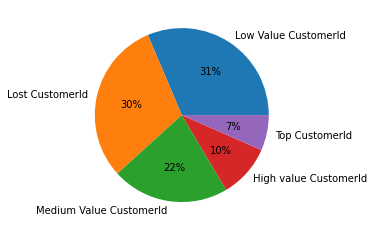

In [10]:
vis_result(rfm_df_score, 'Customer_Segment')


In [12]:
all_markets_recency, all_markets_monetary, all_markets_frequency = main(all_clients, old_market, new_market, 'Market')

rfm_df_market = rfm(all_markets_recency, all_markets_monetary, all_markets_frequency, 'MarketId')
rfm_df_market

,MarketId,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,1.0,0,682012,1.357831e+08,100.000000,95.614035,95.614035
1,2.0,0,833504,2.415128e+08,100.000000,98.245614,98.245614
2,3.0,0,1162982,2.810785e+08,100.000000,100.000000,100.000000
3,4.0,0,460258,1.097189e+08,100.000000,89.473684,89.473684
4,5.0,0,459693,1.224025e+08,100.000000,88.596491,88.596491
...,...,...,...,...,...,...,...
109,710.0,0,938,4.955051e+05,100.000000,16.666667,16.666667
110,711.0,0,2659,1.798192e+06,100.000000,25.438596,25.438596
111,713.0,2,72,5.702888e+04,3.546099,1.754386,1.754386
112,714.0,1,392,5.112073e+05,21.276596,7.894737,7.894737


In [13]:
rfm_df_score_market = rfm_score(rfm_df_market, 'MarketId', 'Market_Segment')
rfm_df_score_market

,MarketId,RFM_Score,Market_Segment
0,1.0,4.81,Top MarketId
1,2.0,4.93,Top MarketId
2,3.0,5.00,Top MarketId
3,4.0,4.55,Top MarketId
4,5.0,4.52,Top MarketId
...,...,...,...
109,710.0,1.46,Lost MarketId
110,711.0,1.83,Low Value MarketId
111,713.0,0.10,Lost MarketId
112,714.0,0.50,Lost MarketId


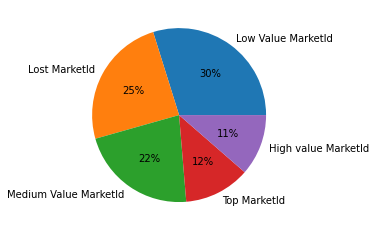

In [14]:
vis_result(rfm_df_score_market, 'Market_Segment')
